Most content in this notebook is aggregated and adapted from the Pyemma tutorials at:

http://www.emma-project.org/latest/tutorial.html#jupyter-notebook-tutorials

Those notebooks break down each step of the MSM pipeline and apply the analysis to multiple test systems of increasing complexity. Here we have combined pieces of each of the first five notebook on the same test system: Alanine Dipeptide.

In addition to packages already installed in your moleng37, you will need to install the packages below in order to run all the cells:

    - conda install mdshare nglview pyemmma
    
Alternatively you may just follow along the outputs without re-running all the cells yourself

# 01 - Data-I/O and featurization

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

In this notebook, we will cover how to load (and visualize) data with PyEMMA.
We are going to extract different features (collective variables)
and compare how well these are suited for Markov state model building.
Further, we will introduce the concept of streaming data, which is mandatory to work with large data sets.

As with the other notebooks, we employ multiple examples.
The idea is, first, to highlight the fundamental ideas with a non-physical test system (diffusion in a 2D double-well potential)
and, second, to demonstrate real-world applications with molecular dynamics data.

Maintainers: [@cwehmeyer](https://github.com/cwehmeyer), [@marscher](https://github.com/marscher), [@thempel](https://github.com/thempel), [@psolsson](https://github.com/psolsson)

**Remember**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA.org](http://www.pyemma.org).

In [304]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma
# for visualization of molecular structures:
import mdtraj
from threading import Timer

import nglview
from nglview.player import TrajectoryPlayer
from matplotlib.colors import to_hex

Both functions make a two-dimensional histogram for the given features;
the free energy surface is defined by the negative logarithm of the probability computed from the histogram counts.

⚠️ Please note that these functions visualize the density and free energy of the **sampled data**,
not the equilibrium distribution of the underlying system.
To account for nonequiblibrium data, you can supply frame-wise weights using the `weights` parameter.
This will be covered in the follow-up [Notebook 04 ➜ 📓](04-msm-analysis.ipynb).

## Case 2: loading `*.xtc` files (alanine dipeptide)

To load molecular dynamics data from one of the standard file formats ( `*.xtc`),
we need not only the actual simulation data, but a topology file, too.
This might differ for other formats though.

In [305]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')
print(pdb)
print(files)

data/alanine-dipeptide-nowater.pdb
['data/alanine-dipeptide-0-250ns-nowater.xtc', 'data/alanine-dipeptide-1-250ns-nowater.xtc', 'data/alanine-dipeptide-2-250ns-nowater.xtc']


#### Visualize with NGLview

We can have a look at the structure with the aid of NGLView.
We load the PDB file into memory with mdtraj and visualize it.
The widget will auto-close after 30 second;
if you want to watch it again, please execute the cell below again.

In [306]:
widget = nglview.show_mdtraj(mdtraj.load(pdb))
p = TrajectoryPlayer(widget)
widget.add_ball_and_stick()
p.spin = True
def stop_spin():
    p.spin = False
    widget.close()
    
#Timer(300, stop_spin).start()
widget

NGLWidget()

In PyEMMA, the `featurizer` is a central object that incorporates the system's topology.
We start by creating it using the topology file.
Features are now easily computed by adding the target feature.
If no feature is added, the featurizer will extract Cartesian coordinates.

Next, we start adding features which we want to extract from the simulation data.
Here, we want to load the backbone torsions,
because these angles are known to describe all flexibility in the system.
Since this feature is two dimensional, it is also easier to visualize.
Please note that, in complex systems, it is not trivial to visualize plain input features.

In [307]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)

⚠️ Please note that the trajectories have been aligned to a reference structure before.
Since in that case we loose track of the periodic box,
we have to switch off the `periodic` flag for the torsion angle computations.
By default PyEMMA assumes your simulation uses periodic boundary conditions.

We can always call the featurizer's `describe()` method to show which features are requested.
You might have noticed that you can combine arbitrary features by having multiple calls to `add_` methods of the featurizer.

In [308]:
data = pyemma.coordinates.load(files, features=feat)

print('type of data:', type(data))
print('shape of elements:', np.shape(data))

Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

type of data: <class 'list'>
shape of elements: (3, 250000, 2)


After we have selected all desired features,
we can call the `load()` function to load all features into memory or,
alternatively, the `source()` function to create a streamed feature reader.
For now, we will use `load()`:

In [309]:
print(feat.describe())

['PHI 0 ALA 2', 'PSI 0 ALA 2']


Apparently, we have loaded a list of three two-dimensional `numpy.ndarray` objects from our three trajectory files.
We can visualize these features using the aforementioned plotting functions,
but to do so we have to concatenate the three individual trajectories:

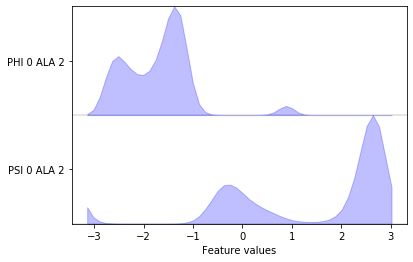

In [310]:
data_concatenated = np.concatenate(data)
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat);

We can now measure the quantity of kinetic variance of the just selected feature by computing a VAMP-2 score <a id="ref-1" href="#cite-vamp-preprint">wu-17</a>.
This enables us to distinguish features on how well they might be suited for MSM building.
The minimum value of this score is $1$, which corresponds to the invariant measure or the observed equilibrium.

With the dimension parameter we specify the amount of dynamic processes that we want to score.
This is of importance later on, when we want to compare different input features
([Notebook 02 ➜ 📓](02-dimension-reduction-and-discretization.ipynb)).
If we did not fix this number, we would not have an upper bound for the score.

⚠️ Please also note that we split our available data into training and test sets,
where we leave out the last file in training and then use it as test.
This is an important aspect in practice to avoid over-fitting the score.

In [311]:
score_phi_psi = pyemma.coordinates.vamp(data[:-1], dim=2).score(
        test_data=data[-1],
        score_method='VAMP2')

print('VAMP2-score backbone torsions: {:.2f}'.format(score_phi_psi))

VAMP2-score backbone torsions: 1.50


The score of $1.5$ means that we have the constant of $1$ plus a total contribution of $0.5$ from the other dynamic processes.

We now use PyEMMA's `plot_density()` and `plot_free_energy()` functions to create Ramachandran plots of our system:

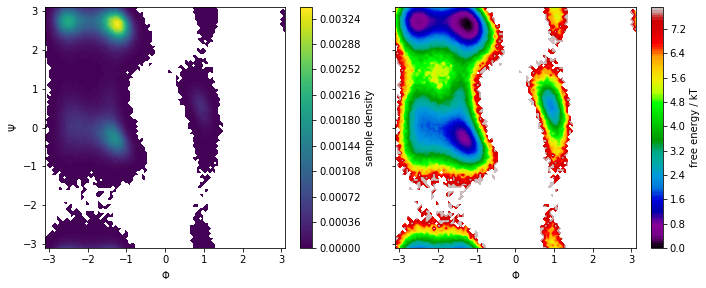

In [312]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
# the * operator used in a function call is used to unpack
# the iterable variable into its single elements. 

pyemma.plots.plot_density(*data_concatenated.T, ax=axes[0])
pyemma.plots.plot_free_energy(*data_concatenated.T, ax=axes[1], legacy=False)
for ax in axes.flat:
    ax.set_xlabel('$\Phi$')
    ax.set_aspect('equal')
axes[0].set_ylabel('$\Psi$')
fig.tight_layout()

We note that the distribution in backbone torsion space contains several basins that will be assigned to metastable states in follow-up notebooks ([Notebook 05 ➜ 📓](05-pcca-tpt.ipynb), [Notebook 07 ➜ 📓](07-hidden-markov-state-models.ipynb)).
Again, the free energy plot only depicts a pseudo free energy surface of the sampled data and was not re-weighted to equilibrium.

Let us look at a different featurization example and load the positions of all heavy atoms instead.
We create a new featurizer object and use its `add_selection()` method to request the positions of a given selection of atoms.
For this selection, we can use the `select_Heavy()` method which returns the indices of all heavy atoms.

Again, we load the data into memory and show what we loaded using the `describe()` method:

Again we have a look at the VAMP-2 score of the heavy atom coordinates.

As we see, the score for the heavy atom positions is much higher as the one for the $\phi/\psi$ torsion angles.
The feature with a higher score should be favored for further analysis,
because it means that this feature contains more information about slow processes.
If you are already digging deeper into your system of interest,
you can of course restrict the analysis to a set of features you already know describes your processes of interest,
regardless of its VAMP score.

Another featurization that is interesting especially for proteins are pairwise heavy atom distances:

In [313]:
feat_dist = pyemma.coordinates.featurizer(pdb)
heavy_atom_distance_pairs = feat_dist.pairs(feat_dist.select_Heavy())
feat_dist.add_distances(heavy_atom_distance_pairs, periodic=False)
data_dist = pyemma.coordinates.load(files, features=feat_dist)

print(np.shape(data_dist))
feat_dist.describe()

Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

(3, 250000, 45)


['DIST: ACE 1 CH3 1 - ACE 1 C 4',
 'DIST: ACE 1 CH3 1 - ACE 1 O 5',
 'DIST: ACE 1 CH3 1 - ALA 2 N 6',
 'DIST: ACE 1 CH3 1 - ALA 2 CA 8',
 'DIST: ACE 1 CH3 1 - ALA 2 CB 10',
 'DIST: ACE 1 CH3 1 - ALA 2 C 14',
 'DIST: ACE 1 CH3 1 - ALA 2 O 15',
 'DIST: ACE 1 CH3 1 - NME 3 N 16',
 'DIST: ACE 1 CH3 1 - NME 3 C 18',
 'DIST: ACE 1 C 4 - ACE 1 O 5',
 'DIST: ACE 1 C 4 - ALA 2 N 6',
 'DIST: ACE 1 C 4 - ALA 2 CA 8',
 'DIST: ACE 1 C 4 - ALA 2 CB 10',
 'DIST: ACE 1 C 4 - ALA 2 C 14',
 'DIST: ACE 1 C 4 - ALA 2 O 15',
 'DIST: ACE 1 C 4 - NME 3 N 16',
 'DIST: ACE 1 C 4 - NME 3 C 18',
 'DIST: ACE 1 O 5 - ALA 2 N 6',
 'DIST: ACE 1 O 5 - ALA 2 CA 8',
 'DIST: ACE 1 O 5 - ALA 2 CB 10',
 'DIST: ACE 1 O 5 - ALA 2 C 14',
 'DIST: ACE 1 O 5 - ALA 2 O 15',
 'DIST: ACE 1 O 5 - NME 3 N 16',
 'DIST: ACE 1 O 5 - NME 3 C 18',
 'DIST: ALA 2 N 6 - ALA 2 CA 8',
 'DIST: ALA 2 N 6 - ALA 2 CB 10',
 'DIST: ALA 2 N 6 - ALA 2 C 14',
 'DIST: ALA 2 N 6 - ALA 2 O 15',
 'DIST: ALA 2 N 6 - NME 3 N 16',
 'DIST: ALA 2 N 6 - NME 3 C

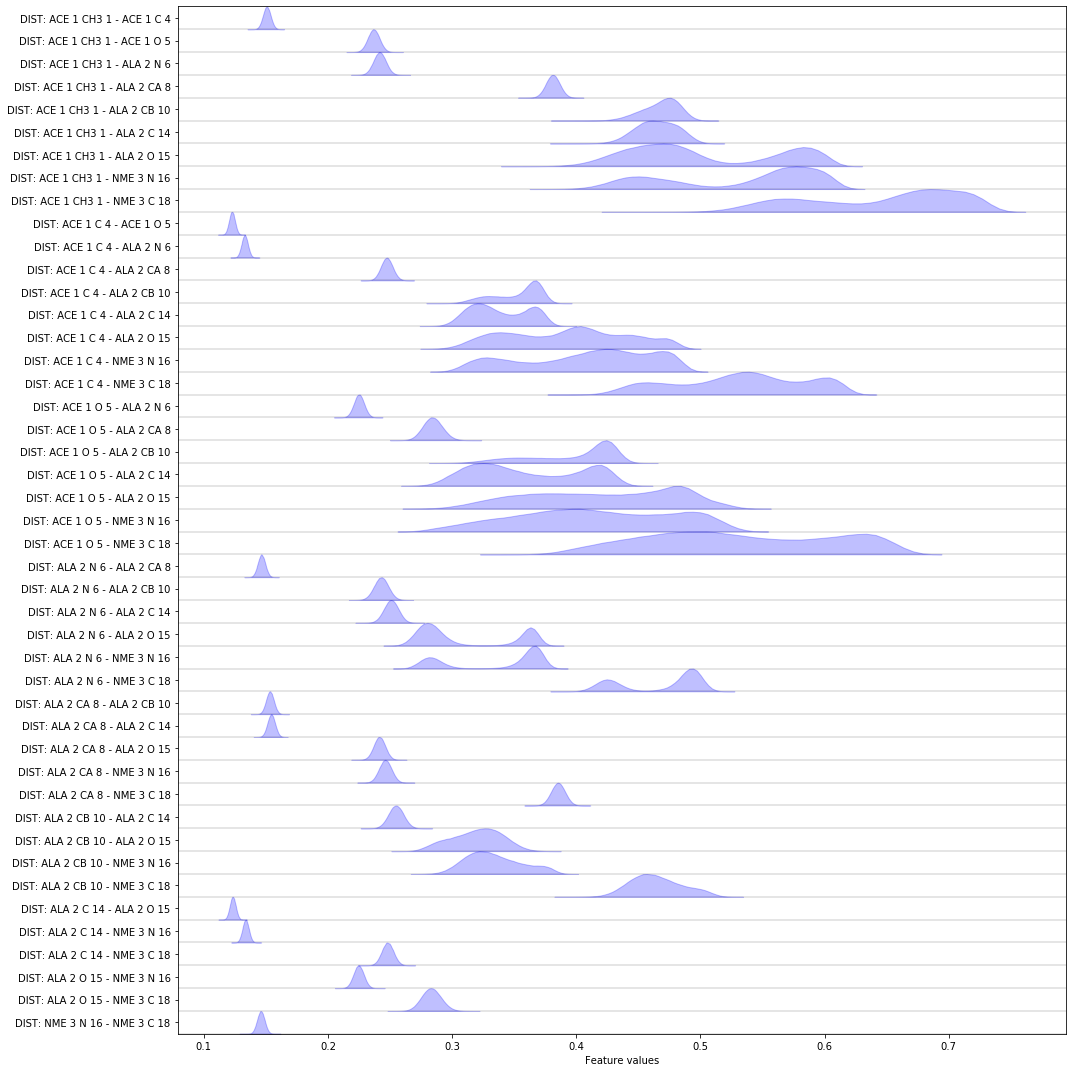

In [314]:
fig, ax = plt.subplots(figsize=(15, 15))
pyemma.plots.plot_feature_histograms(np.concatenate(data_dist), feature_labels=feat_dist, ax=ax)
fig.tight_layout()

Now let us compare the score of heavy atom distance pairs to the other scores.

In [315]:
data_dist_conc = np.concatenate(data_dist)
sparse_data = []
n_sparse = 0

# remove low variance features
for cv in range(data_dist_conc.shape[-1]):
    if np.std(data_dist_conc[:, cv]) > 0.005:
        sparse_data.append(data_dist_conc[:, cv])
        n_sparse += 1
        
sparse_data = np.array(sparse_data).T
n_traj, n_frames = np.shape(data_dist)[0], np.shape(data_dist)[1]
sparse_data = [sparse_data[n*n_frames:(n+1)*n_frames] for n in range(n_traj)]

print(f'all distance dimensionality = {np.shape(data_dist)}')
print(f'sparse data dimensionality  = {np.shape(sparse_data)}\n')

del data_dist_conc

score_heavy_atoms = pyemma.coordinates.vamp(data_dist[:-1], dim=2).score(
        test_data= data_dist[-1],
        score_method='VAMP2')

score_sparse_atoms = pyemma.coordinates.vamp(sparse_data[:-1], dim=2).score(
        test_data= sparse_data[-1],
        score_method='VAMP2')

print('VAMP2-score backbone torsions: {:f}'.format(score_phi_psi))
print('VAMP2-score all pairwise distances: {:f}'.format(score_heavy_atoms))
print('VAMP2-score sparse distances: {:f}'.format(score_sparse_atoms))

all distance dimensionality = (3, 250000, 45)
sparse data dimensionality  = (3, 250000, 30)

VAMP2-score backbone torsions: 1.502240
VAMP2-score all pairwise distances: 2.404950
VAMP2-score sparse distances: 2.386547


# 02 - Dimension reduction and discretization

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

In this notebook, we will cover how to perform dimension reduction and discretization of molecular dynamics data. We also repeat data loading and visualization tasks from [Notebook 01 ➜ 📓](01-data-io-and-featurization.ipynb).

Maintainers: [@cwehmeyer](https://github.com/cwehmeyer), [@marscher](https://github.com/marscher), [@thempel](https://github.com/thempel), [@psolsson](https://github.com/psolsson)

**Remember**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA.org](http://www.pyemma.org).

initialize kmeans++ centers:   0%|          | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

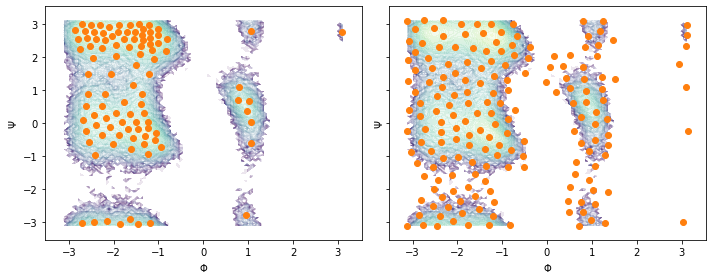

In [316]:
cluster_kmeans = pyemma.coordinates.cluster_kmeans(data, k=100, max_iter=50, stride=5)
cluster_regspace = pyemma.coordinates.cluster_regspace(data, dmin=0.3)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, cls in zip(axes.flat, [cluster_kmeans, cluster_regspace]):
    pyemma.plots.plot_density(*data_concatenated.T, ax=ax, cbar=False, alpha=0.1, logscale=True)
    ax.scatter(*cls.clustercenters.T, c='C1') # s=15
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()

Again, notice the difference between $k$-means and regspace clustering.

Now, we use a different featurization for the same data set and revisit how to use PCA, TICA, and VAMP.

⚠️ In practice you almost never would like to use PCA as dimension reduction method in MSM building,
as it does not preserve kinetic variance. We are showing it here in these exercises to make this point clear.

####  PCA visualization

Discretizing a $45$-dimensional feature space is impractical.
Let's use PCA to find a low-dimensional projection and visualize the marginal distributions of all principal components (PCs) as well as the joint distributions for the first two PCs:

calc mean+cov:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of PCA:   0%|          | 0/3 [00:00<?, ?it/s]

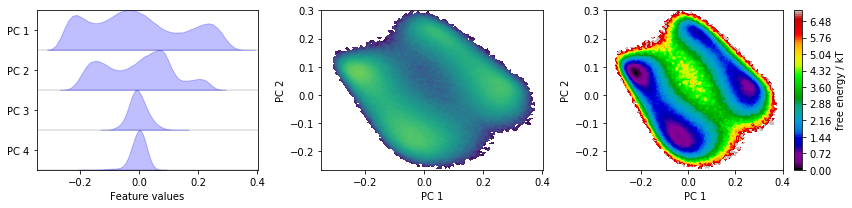

In [317]:
pca = pyemma.coordinates.pca(data_dist) # try sparse_data
pca_concatenated = np.concatenate(pca.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
pyemma.plots.plot_feature_histograms(
    pca_concatenated, ['PC {}'.format(i + 1) for i in range(pca.dimension())], ax=axes[0])
pyemma.plots.plot_density(*pca_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
pyemma.plots.plot_free_energy(*pca_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
fig.tight_layout()

With the default parameters, PCA will return as many dimensions as necessary to explain $95\%$ of the variance;
in this case, we have found a four-dimensional subspace which does seem to resolve some metastability in the first three principal components.

#### TICA visualization

Apply TICA and visualize the marginal distributions of all independent components (ICs) as well as the joint distributions of the first two ICs.

calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

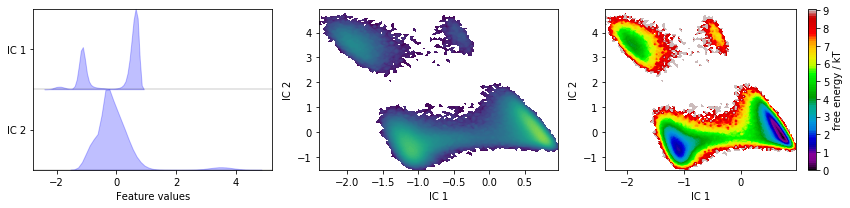

In [318]:
tica = pyemma.coordinates.tica(data_dist)
tica_concatenated = np.concatenate(tica.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

TICA, by default, uses a lag time of $10$ steps, kinetic mapping and a kinetic variance cutoff of $95\%$ to determine the number of ICs.
We observe that this projection does resolve some metastability in both ICs.
Whether these projections are suitable for building Markov state models, though, remains to be seen in later tests
([Notebook 03 ➜ 📓](03-msm-estimation-and-validation.ipynb)).

As we discussed in the first example, the physical meaning of the TICA projection is not directly clear.
We can analyze the feature TIC correlation as we did above:

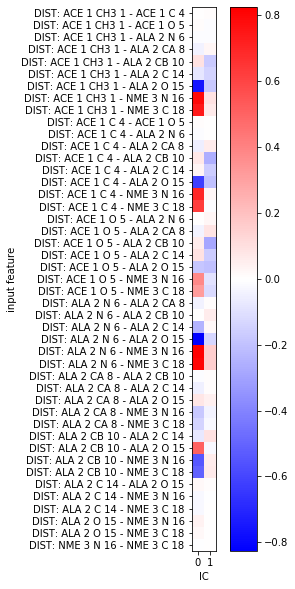

In [319]:
fig, ax = plt.subplots(figsize=(5, 10))
i = ax.imshow(tica.feature_TIC_correlation, cmap='bwr')

ax.set_xticks(range(tica.dimension()))
ax.set_xlabel('IC')

ax.set_yticks(range(feat_dist.dimension()))
ax.set_yticklabels(feat_dist.describe())
ax.set_ylabel('input feature')

fig.colorbar(i);

This is not helpful as it only shows that some of our distance correlate with the TICA components.
Since we rather expect the slow processes to happen in backbone torsion space, this comes to no surprise. 

To understand what the TICs really mean, let us do a more systematic approach and scan through some angular features.
We add some randomly chosen angles between heavy atoms and the backbone angles that we already know to be a good feature:

In [320]:
feat_test = pyemma.coordinates.featurizer(pdb)
feat_test.add_backbone_torsions(periodic=False)
feat_test.add_angles(feat_test.select_Heavy()[:-1].reshape(3, 3), periodic=False)
data_test = pyemma.coordinates.load(files, features=feat_test)
data_test_concatenated = np.concatenate(data_test)

Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

For the sake of simplicity, we use scipy's implementation of Pearson's correlation coefficient which we compute between our test features and TICA projected distance

In [321]:
from scipy.stats import pearsonr
test_feature_TIC_correlation = np.zeros((feat_test.dimension(), tica.dimension()))

for i in range(feat_test.dimension()):
    for j in range(tica.dimension()):
        test_feature_TIC_correlation[i, j] = pearsonr(
            data_test_concatenated[:, i],
            tica_concatenated[:, j])[0]

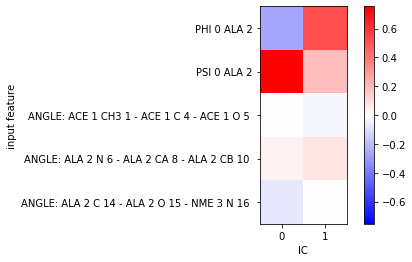

In [322]:
vm = abs(test_feature_TIC_correlation).max()

fig, ax = plt.subplots()
i = ax.imshow(test_feature_TIC_correlation, vmin=-vm, vmax=vm, cmap='bwr')

ax.set_xticks(range(tica.dimension()))
ax.set_xlabel('IC')

ax.set_yticks(range(feat_test.dimension()))
ax.set_yticklabels(feat_test.describe())
ax.set_ylabel('input feature')

fig.colorbar(i);

From this simple analysis, we find that features that correlated most with our TICA projection are indeed the backbone torsion angles used previously.
We might thus expect the dynamics in TICA space to be similar to the one in backbone torsion space.

⚠️ Please note that in general, we do not know which feature would be a good observable.
Thus, a realistic scenario might require a much broader scan of a large set of different features.

However, it should be mentioned that TICA projections do not necessarily have a simple physical interpretation.
The above analysis might very well end with feature TIC correlations that show no significant contributor and rather hint towards a complicated linear combination of input features.

As an alternative to understanding the projection in detail at this stage,
one might go one step further and extract representative structures,
e.g., from an MSM, as shown in [Notebook 05 📓](05-pcca-tpt.ipynb).

#### PCA parameters

Perform PCA on the heavy atoms' positions data set with a target dimension of two;
then discretize the two-dimensional subspace using $k$-means with $100$ centers and a stride of $5$ to reduce the computational effort.

**Hint:** Look up the parameters of `pyemma.coordinates.pca()`, especially the `dim` parameter.

calc mean+cov:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of PCA:   0%|          | 0/3 [00:00<?, ?it/s]

initialize kmeans++ centers:   0%|          | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

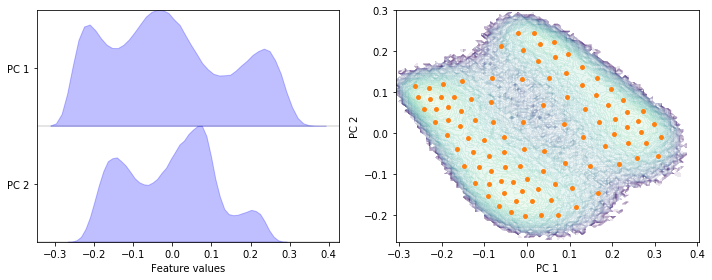

In [323]:
pca = pyemma.coordinates.pca(data_dist, dim=2)
pca_concatenated = np.concatenate(pca.get_output())

cluster = pyemma.coordinates.cluster_kmeans(pca, k=100, max_iter=50, stride=20)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    pca_concatenated, ['PC {}'.format(i + 1) for i in range(pca.dimension())], ax=axes[0])
pyemma.plots.plot_density(*pca_concatenated.T, ax=axes[1], cbar=False, alpha=0.1, logscale=True)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')
fig.tight_layout()

####  TICA parameters

Perform TICA at lag time $1$ step on the heavy atoms' positions data set with a target dimension of two;
then discretize the two-dimensional subspace using $k$-means with $100$ centers and a stride of $5$ to reduce the computational effort.

**Hint:** Look up the parameters of `pyemma.coordinates.tica()`, especially the `dim` and `lag` parameters.

calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

initialize kmeans++ centers:   0%|          | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

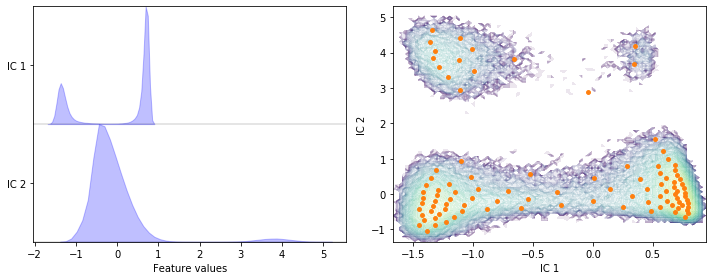

In [324]:
tica = pyemma.coordinates.tica(data_dist, lag=3, dim=2)
tica_concatenated = np.concatenate(tica.get_output())

cluster = pyemma.coordinates.cluster_kmeans(tica, k=100, max_iter=50, stride=10)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated.T, ax=axes[1], cbar=False, alpha=0.1, logscale=True)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

# 03 - MSM estimation and validation

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

In this notebook, we will cover how to estimate a Markov state model (MSM) and do model validation;
we also show how to save and restore model and estimator objects.
For this notebook, you need to know how to do data loading/visualization
([Notebook 01 ➜ 📓](01-data-io-and-featurization.ipynb))
as well as dimension reduction ([Notebook 02 ➜ 📓](02-dimension-reduction-and-discretization.ipynb)).

We further recommend to have a look at the literature, if you are new to the concept of Markov state models:
- <a id="ref-1" href="#cite-msm-jhp">prinz-11</a>
- <a id="ref-2" href="#cite-msm-book">bowman-14</a>
- <a id="ref-3" href="#cite-msm-brooke">husic-18</a>

Maintainers: [@cwehmeyer](https://github.com/cwehmeyer), [@marscher](https://github.com/marscher), [@thempel](https://github.com/thempel), [@psolsson](https://github.com/psolsson)

**Remember**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA.org](http://www.pyemma.org).

#### Convergence for PCA vs. TICA 

Load the heavy atom distances into memory, perform PCA and TICA (`lag=3`) with `dim=2`,
then discretize with $100$ $k$-means centers and a stride of $10$.

In [325]:
pca = pyemma.coordinates.pca(data_dist, dim=2)
tica = pyemma.coordinates.tica(data_dist, lag=3, dim=2)

pca_concatenated = np.concatenate(pca.get_output())
tica_concatenated = np.concatenate(tica.get_output())

cls_pca = pyemma.coordinates.cluster_kmeans(pca, k=100, max_iter=50, stride=10)
cls_tica = pyemma.coordinates.cluster_kmeans(tica, k=100, max_iter=50, stride=10)

its_pca = pyemma.msm.its(
    cls_pca.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')
its_tica = pyemma.msm.its(
    cls_tica.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')

calc mean+cov:   0%|          | 0/3 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of PCA:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

initialize kmeans++ centers:   0%|          | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

initialize kmeans++ centers:   0%|          | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|          | 0/3 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|          | 0/6 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|          | 0/3 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|          | 0/6 [00:00<?, ?it/s]

Let's visualize the ITS convergence for both projections:

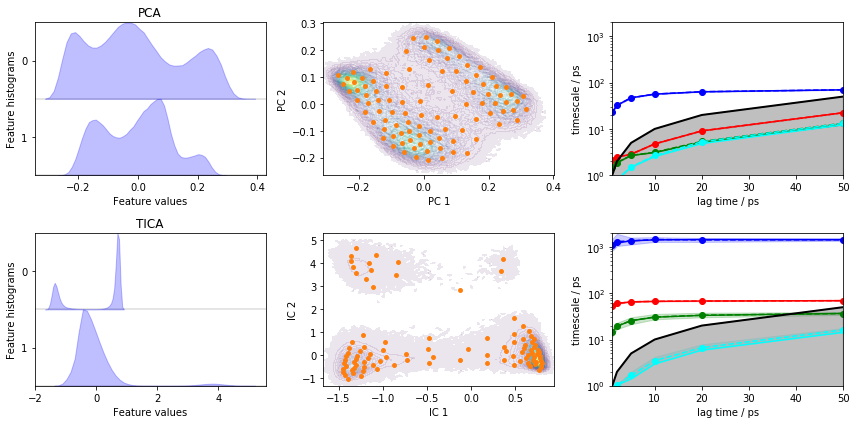

In [326]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
pyemma.plots.plot_feature_histograms(pca_concatenated, ax=axes[0, 0])
pyemma.plots.plot_feature_histograms(tica_concatenated, ax=axes[1, 0])
axes[0, 0].set_title('PCA')
axes[1, 0].set_title('TICA')
pyemma.plots.plot_density(*pca_concatenated.T, ax=axes[0, 1], cbar=False, alpha=0.1)
axes[0, 1].scatter(*cls_pca.clustercenters.T, s=15, c='C1')
axes[0, 1].set_xlabel('PC 1')
axes[0, 1].set_ylabel('PC 2')
pyemma.plots.plot_density(*tica_concatenated.T, ax=axes[1, 1], cbar=False, alpha=0.1)
axes[1, 1].scatter(*cls_tica.clustercenters.T, s=15, c='C1')
axes[1, 1].set_xlabel('IC 1')
axes[1, 1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its_pca, ax=axes[0, 2], units='ps')
pyemma.plots.plot_implied_timescales(its_tica, ax=axes[1, 2], units='ps')
axes[0, 2].set_ylim(1, 2000)
axes[1, 2].set_ylim(1, 2000)
fig.tight_layout()

We observe three resolved processes with flat ITS for a lag time of approximately $10$ ps.

Please note though that this ITS convergence analysis is based on the assumption that $200$ $k$-means centers are sufficient to discretize the dynamics.
In order to study the influence of the clustering on the ITS convergence,
we repeat the clustering and ITS convergence analysis for various number of cluster centers.
For the sake of simplicity, we will restrict ourselves to the $k$-means algorithm; alternative clustering methods are presented in [Notebook 02 ➜ 📓](02-dimension-reduction-and-discretization.ipynb).

initialize kmeans++ centers:   0%|          | 0/5 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|          | 0/3 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|          | 0/6 [00:00<?, ?it/s]

initialize kmeans++ centers:   0%|          | 0/10 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|          | 0/3 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|          | 0/6 [00:00<?, ?it/s]

initialize kmeans++ centers:   0%|          | 0/20 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|          | 0/3 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|          | 0/6 [00:00<?, ?it/s]

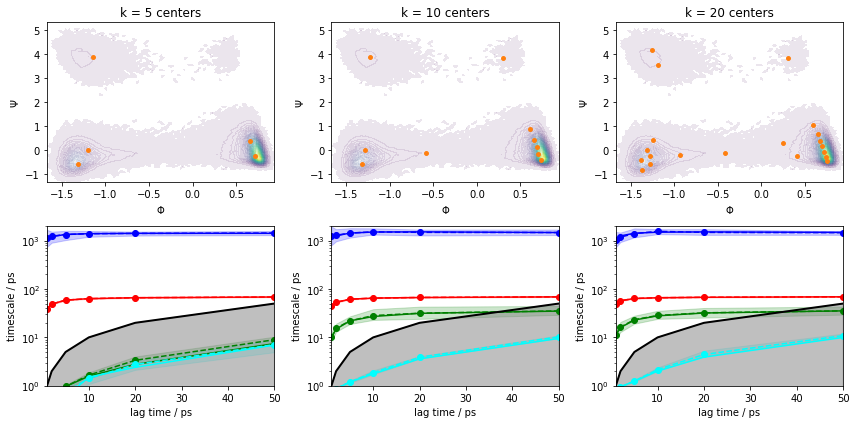

In [340]:

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, k in enumerate([5, 10, 20]):
    cluster = pyemma.coordinates.cluster_kmeans(tica, k=k, max_iter=50, stride=10)
    pyemma.plots.plot_density(*tica_concatenated.T, ax=axes[0, i], cbar=False, alpha=0.1)
    axes[0, i].scatter(*cluster.clustercenters.T, s=15, c='C1')
    axes[0, i].set_xlabel('$\Phi$')
    axes[0, i].set_ylabel('$\Psi$')
    axes[0, i].set_title('k = {} centers'.format(k))
    pyemma.plots.plot_implied_timescales(
        pyemma.msm.its(cluster.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes'),
        ax=axes[1, i], units='ps')
    axes[1, i].set_ylim(1, 2000)
fig.tight_layout()

# 04 - MSM analysis

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

In this notebook, we will cover how to analyze an MSM and how the modeled processes correspond to MSM spectral properties.
We assume that you are familiar with data loading/visualization
([Notebook 01 ➜ 📓](01-data-io-and-featurization.ipynb)),
dimension reduction ([Notebook 02 ➜ 📓](02-dimension-reduction-and-discretization.ipynb)), and
the estimation and validation process ([Notebook 03 ➜ 📓](03-msm-estimation-and-validation.ipynb)).

Maintainers: [@cwehmeyer](https://github.com/cwehmeyer), [@marscher](https://github.com/marscher), [@thempel](https://github.com/thempel), [@psolsson](https://github.com/psolsson)

**Remember**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA.org](http://www.pyemma.org).

#### Stationary distribution

initialize kmeans++ centers:   0%|          | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|          | 0/3 [00:00<?, ?it/s]

fraction of states used = 1.000000
fraction of counts used = 1.000000


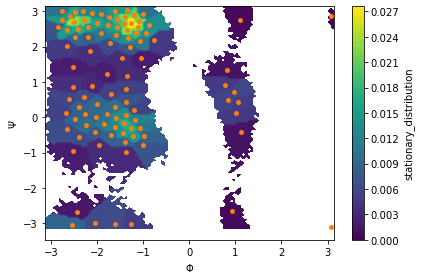

In [341]:
cluster = pyemma.coordinates.cluster_kmeans(data, k=100, max_iter=50, stride=20)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=10, dt_traj='1 ps')

print('fraction of states used = {:f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:f}'.format(msm.active_count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *data_concatenated.T, msm.pi[dtrajs_concatenated],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
fig.tight_layout()

#### Eigenvectors describe transitions between states

first eigenvector is one: True (min=0.9999999999999944, max=1.0000000000000673)


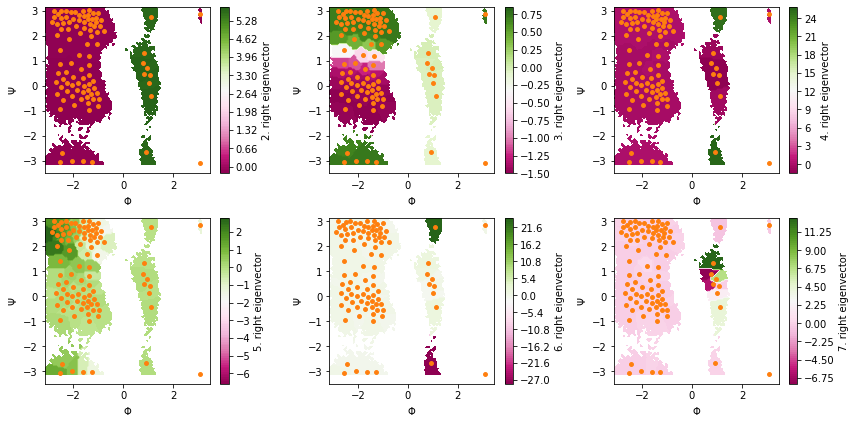

In [342]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *data_concatenated.T, eigvec[dtrajs_concatenated, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()

Again, we have the $(1,\dots,1)^\top$ first right eigenvector of the stationary process.

The second to fourth right eigenvectors illustrate the three slowest processes which are (in that order):

- rotation of the $\Phi$ dihedral,
- rotation of the $\Psi$ dihedral when $\Phi\approx-2$ rad, and
- rotation of the $\Psi$ dihedral when $\Phi\approx1$ rad.

Eigenvectors five, six, and seven indicate further processes which, however, relax faster than the lag time and cannot be resolved clearly.

We now proceed our validation process using a Bayesian MSM with four metastable states:

In [343]:
cluster.save('nb4.pyemma', model_name='ala2_cluster', overwrite=True)
msm.save('nb4.pyemma', model_name='ala2_msm', overwrite=True)
bayesian_msm.save('nb4.pyemma', model_name='ala2_bayesian_msm', overwrite=True)

#msm = pyemma.load('nb4.pyemma', model_name='ala2_msm')
#bayesian_msm = pyemma.load('nb4.pyemma', model_name='ala2_bayesian_msm')
#cluster = pyemma.load('nb4.pyemma', model_name='ala2_cluster')

11-03-21 12:23:23 pyemma._base.serialization.h5file INFO     overwriting model "ala2_cluster" in file nb4.pyemma


INFO:pyemma._base.serialization.h5file:overwriting model "ala2_cluster" in file nb4.pyemma


11-03-21 12:23:24 pyemma._base.serialization.h5file INFO     overwriting model "ala2_msm" in file nb4.pyemma


INFO:pyemma._base.serialization.h5file:overwriting model "ala2_msm" in file nb4.pyemma


11-03-21 12:23:24 pyemma._base.serialization.h5file INFO     overwriting model "ala2_bayesian_msm" in file nb4.pyemma


INFO:pyemma._base.serialization.h5file:overwriting model "ala2_bayesian_msm" in file nb4.pyemma


# 05 - PCCA and TPT analysis

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

In this notebook, we will cover how to use PCCA++ to extract a coarse representation of the MSM.
We will further investigate how to use transition path theory (TPT) to follow the pathways of the processes.
When we want to analyze pathways, models with fewer states are more often desirable, since these are easier to understand.
PCCA++ allows us to assign the microstates directly to metastable macrostates and TPT uses this group assignment to compute fluxes and pathways.

Another method to get a model with fewer states are hidden Markov state models (HMM),
introduced in [Notebook 07 ➜ 📓](07-hidden-markov-state-models.ipynb).
In contrast to computing memberships of microstates to meta stable sets as in PCCA++,
in HMMs we directly obtain a model with fewer states.

While we will mostly rely on previously estimated/validated models, it will be helpful to understand the topics
- data loading/visualization ([Notebook 01 ➜ 📓](01-data-io-and-featurization.ipynb))
- dimension reduction ([Notebook 02 ➜ 📓](02-dimension-reduction-and-discretization.ipynb))
- the estimation and validation process ([Notebook 03 ➜ 📓](03-msm-estimation-and-validation.ipynb))

Here you can find literature on the used methods:
- <a id="ref-1" href="#cite-pcca_plus_plus">roeblitz-weber-14</a>
- <a id="ref-2" href="#cite-weinan-tpt">weinan-06</a>
- <a id="ref-3" href="#cite-metzner-msm-tpt">metzner-09</a>

Maintainers: [@cwehmeyer](https://github.com/cwehmeyer), [@marscher](https://github.com/marscher), [@thempel](https://github.com/thempel), [@psolsson](https://github.com/psolsson)

**Remember**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA.org](http://www.pyemma.org).

---

⚠️ We have assigned the integer numbers $1 \dots $ `nstates` to PCCA++ metastable states.
As PyEMMA is written in Python, it internally indexes states starting from $0$.
In consequence, numbers in the code cells differ by $-1$ from the plot labels and markdown text.

In [331]:
nstates = 4
pcca = msm.pcca(nstates)
for i, s in enumerate(msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm.pi[s].sum()))

π_1 = 0.001555
π_2 = 0.028310
π_3 = 0.327718
π_4 = 0.642417


We visualize the metastable memberships:

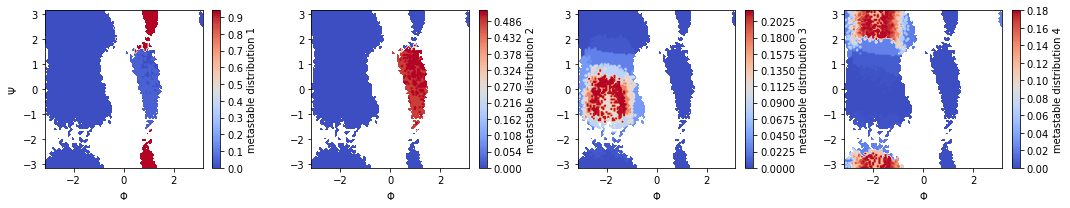

In [332]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    
    pyemma.plots.plot_contour(
        *data_concatenated.T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap= 'coolwarm', #'afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))

    ax.set_xlabel('$\Phi$')
axes[0].set_ylabel('$\Psi$')
fig.tight_layout()

PCCA++ nicely separates the high-density regions and we find that each of the basins was assigned a metastable set.
This indicates that our projection indeed describes the slow dynamics.

We concatenate all three discrete trajectories and obtain a single trajectory of metastable states which we use to visualize the metastable state memberships of all datapoints.
We further compute the state with the highest membership to a PCCA metastable state to plot a state label there.

⚠️ Please remember that the concatenated discrete trajectories (dtrajs) are not meant to be used for MSM estimation (artificial transitions), but only for visualization and indexing purposes!

In [333]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]

Now, we use the `mfpt()` method of the MSM object to compute MFPTs between pairs of metastable sets and compute the inverse MFPTs for visualization purposes:

In [334]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

We visualize our model in backbone torsion space:

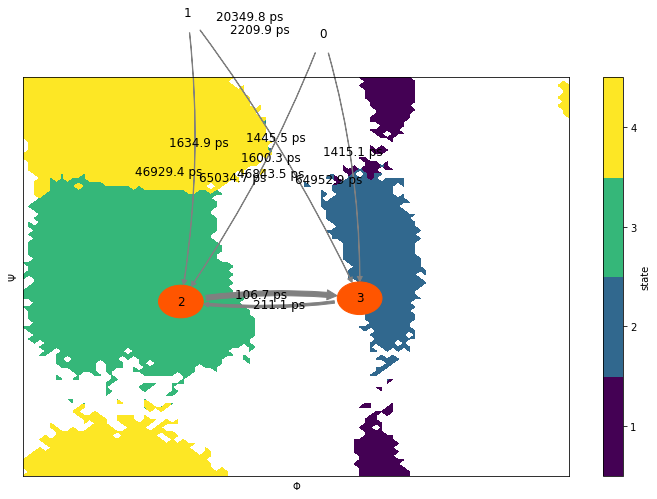

In [335]:
fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *data_concatenated.T, metastable_traj, ax=ax, zorder=-1)
misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers,
    figpadding=0,
    arrow_label_format='%.1f ps',
    arrow_labels=mfpt,
    size=12,
    show_frame=True,
    ax=ax)

ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
fig.tight_layout()

Have you noticed how well the metastable state coloring agrees with the eigenvector visualization of the three slowest processes?

If we could afford a shorter lag time, we might even be able to resolve more processes and, thus,
subdivide the metastable states three and four.
We show how to do this with HMMs in [Notebook 07 ➜ 📓](07-hidden-markov-state-models.ipynb).


Coming back to TPT, we now have more than two metastable states and can expect more insights from analyzing the transition paths.
As an example, we will focus on the committor between metastable sets $0$ and $3$ as defined above.

In [336]:
A = msm.metastable_sets[0]
B = msm.metastable_sets[3]
flux = pyemma.msm.tpt(msm, A, B)

Before we go on with the visualization, let's coarse grain the flux with the metastable sets estimated with PCCA++:

In [337]:
cg, cgflux = flux.coarse_grain(msm.metastable_sets)

We now show an overlay of the committor probabilities and the most likely transition path from the coarse graining TPT:

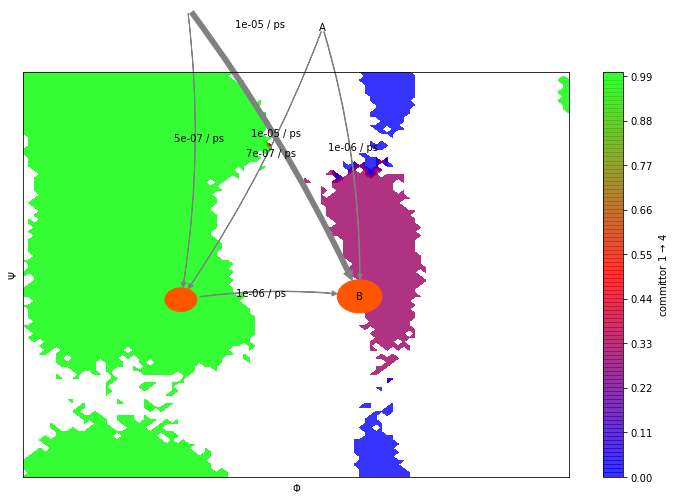

In [338]:
fig, ax = plt.subplots(figsize=(10, 7))

pyemma.plots.plot_contour(
    *data_concatenated.T,
    flux.committor[dtrajs_concatenated],
    cmap='brg',
    ax=ax,
    mask=True,
    cbar_label=r'committor 1 $\to$ 4',
    alpha=0.8,
    zorder=-1);

pyemma.plots.plot_flux(
    cgflux,
    coarse_state_centers,
    cgflux.stationary_distribution,
    state_labels=['A','' ,'', 'B'], 
    ax=ax,
    show_committor=False,
    figpadding=0,
    show_frame=True,
    arrow_label_format='%2.e / ps');

ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
fig.tight_layout()

First, the color map shows us a region with committor probability $\approx 0.5$.
This indicates that this particular metastable state is a transition state in the pathway from $A$ to $B$.
Second, the `plot_flux()` function displays the most likely transition pathway along this path.
There are other, less likely pathways included in the plot as well.
The arrow thickness indicates the flux between the states.

We can decompose the flux into these individual pathways by:

In [339]:
paths, path_fluxes = cgflux.pathways(fraction=0.99)
print('percentage       \tpath')
print('-------------------------------------')
for i in range(len(paths)):
    print(np.round(path_fluxes[i] / np.sum(path_fluxes), 3),' \t', paths[i] + 1)

percentage       	path
-------------------------------------
0.829  	 [1 2 4]
0.089  	 [1 4]
0.049  	 [1 3 4]
0.034  	 [1 2 3 4]


As expected, about $85\%$ of the flux goes through only one pathway.
To get a cleaner picture, the `plot_flux()` function supports a `minflux` keyword argument that can be increased to exclude very low fluxes from the plot.

